# Libraries

In [5]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, precision_recall_fscore_support,
                             confusion_matrix, roc_curve, auc)
from sklearn.inspection import permutation_importance

# Setup

In [ ]:
plt.rcParams.update({'font.size': 20})

In [7]:
# Load test dataset
df_test = pd.read_parquet("../data/final/test_data.parquet")

# Drop classification target to avoid leakage
df_test = df_test.drop(columns=['DepDelayMinutes'])

# Extract features and target
X_test = df_test.drop(columns=['DepDel15'])
y_test = df_test['DepDel15'].values.ravel()

In [8]:
classification_models_base = {
    "Log Regression (Base)": "../models/log_reg/log_reg_base.pkl",
    "SGD Classifier (Base)": "../models/sgd_clf/sgd_clf_base.pkl",
    "HGB Classifier (Base)": "../models/hgb_clf/hgb_clf_base.pkl",
    "MLP Classifier (Base)": "../models/mlp_clf/mlp_clf_base.pkl"
}

classification_models = {
    "Log Regression": "../models/log_reg/log_reg_tuned.pkl",
    "SGD Classifier": "../models/sgd_clf/sgd_clf_tuned.pkl",
    "HGB Classifier": "../models/hgb_clf/hgb_clf_tuned.pkl",
    "MLP Classifier": "../models/mlp_clf/mlp_clf_tuned.pkl"
}

# Helper Functions

In [9]:
def clf_evaluater(models_dict, X_test, y_test):
    """Loads and evaluates classification models, returns model predictions."""
    classification_results = []
    model_predictions = {}

    for model_name, file in models_dict.items():
        with open(file, "rb") as f:
            model = pickle.load(f)

        # Make predictions
        y_pred = model.predict(X_test)
        model_predictions[model_name] = y_pred  # Store standard predictions

        # Store probability estimates if available
        if hasattr(model, "predict_proba"):
            model_predictions[model_name + " Prob"] = model.predict_proba(X_test)[:, 1]
        elif hasattr(model, "decision_function"):
            model_predictions[model_name + " Prob"] = model.decision_function(X_test)

        # Compute evaluation metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average="binary")

        classification_results.append({
            "Model": model_name,
            "Accuracy": accuracy,
            "Precision": precision,
            "Recall": recall,
            "F1-Score": f1
        })

    # Return results DataFrame and predictions dictionary
    return pd.DataFrame(classification_results), model_predictions

In [10]:
def clf_performance_plotter(df_results):
    """Plots a bar chart comparing classification model performance."""
    plt.figure(figsize=(10, 6))
    df_results.set_index("Model").plot(kind="bar", figsize=(10, 6))
    plt.title("Classification Model Performance Comparison")
    plt.ylabel("Metric Value")
    plt.xticks(rotation=45)
    plt.grid()
    plt.show()

In [11]:
def clf_confusion_matrices(models_dict, model_predictions, y_test):
    """Plots a 2x2 grid of confusion matrices for all models."""
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    axes = axes.ravel()  # Flatten the 2D array for easier iteration
    vmin, vmax = None, None  # Store global min/max for shared color bar

    # First pass to find color scale range
    cms = {}
    for model_name in models_dict.keys():
        cm = confusion_matrix(y_test, model_predictions[model_name])
        cms[model_name] = cm
        if vmin is None or cm.min() < vmin:
            vmin = cm.min()
        if vmax is None or cm.max() > vmax:
            vmax = cm.max()

    # Second pass to plot confusion matrices
    for i, model_name in enumerate(models_dict.keys()):
        sns.heatmap(cms[model_name], annot=True, fmt='d', cmap="Blues", ax=axes[i], vmin=vmin, vmax=vmax)
        axes[i].set_title(f"{model_name}")
        axes[i].set_xlabel("Predicted")
        axes[i].set_ylabel("Actual")

    # Adjust layout
    plt.suptitle("Confusion Matrices")
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

In [12]:
def clf_auc_plotter(models_dict, model_predictions, y_test):
    """Plots ROC Curves for models that support probability estimation."""
    plt.figure(figsize=(8, 6))
    for model_name in models_dict.keys():
        prob_key = model_name + " Prob"
        if prob_key in model_predictions:
            fpr, tpr, _ = roc_curve(y_test, model_predictions[prob_key])
            plt.plot(fpr, tpr, label=f"{model_name} (AUC = {auc(fpr, tpr):.2f})")

    plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curves")
    plt.legend()
    plt.show()

In [13]:
def clf_permutation_importance(models_dict, X_test, y_test, scoring="accuracy", n_repeats=5, frac=0.1):
    """Computes permutation importance with parallel processing and ensures stratified sampling.
       Returns a DataFrame with feature importances and a DataFrame of top 5 features per model.
    """
    feature_importances = {}
    top_features = {}

    # Stratified sampling to maintain class distribution
    if frac < 1.0:
        X_test_sample, _, y_test_sample, _ = train_test_split(
            X_test, y_test, test_size=(1-frac), stratify=y_test, random_state=42
        )
    else:
        X_test_sample, y_test_sample = X_test, y_test

    for model_name, file in models_dict.items():
        with open(file, "rb") as f:
            model = pickle.load(f)

        # Compute permutation importance with parallel processing
        result = permutation_importance(
            model, X_test_sample, y_test_sample,
            scoring=scoring, n_repeats=n_repeats, random_state=42, n_jobs=-1
        )

        # Store feature importance scores
        feature_importances[model_name] = result.importances_mean

        # Get top 5 features for the current model
        sorted_indices = result.importances_mean.argsort()[::-1][:5]
        top_features[model_name] = X_test.columns[sorted_indices].tolist()

    # Convert to DataFrame
    df_importance = pd.DataFrame(feature_importances, index=X_test.columns)

    # Compute global importance ranking
    df_importance["Mean Importance"] = df_importance.mean(axis=1)
    df_importance["Feature"] = df_importance.index  # Add feature names inside the DataFrame
    df_importance["Rank"] = df_importance["Mean Importance"].rank(ascending=False)

    # Sort by mean importance
    df_importance = df_importance.sort_values(by="Mean Importance", ascending=False)

    # Reorder columns: Rank (as index), Feature, Models..., Mean Importance
    column_order = ["Feature"] + list(models_dict.keys()) + ["Mean Importance"]
    df_importance = df_importance[["Rank"] + column_order]
    
    df_importance.set_index("Rank", inplace=True)  # Set Rank as the index

    # Convert top features dictionary into DataFrame and transpose
    df_top_features = pd.DataFrame.from_dict(top_features, orient='index').T
    df_top_features.index = range(1, 6)  # Ranking from 1 to 5
    df_top_features.index.name = "Rank"  # Set index name to Rank
    
    return df_importance, df_top_features

# Results

### Base Model Results

In [14]:
df_clf_base, clf_preds_base = clf_evaluater(classification_models_base, X_test, y_test)
df_clf_base

,Model,Accuracy,Precision,Recall,F1-Score
0,Log Regression (Base),0.646027,0.651706,0.641408,0.646516
1,SGD Classifier (Base),0.642787,0.644449,0.651809,0.648108
2,HGB Classifier (Base),0.661882,0.676312,0.632984,0.653931
3,MLP Classifier (Base),0.661081,0.679159,0.622539,0.649618


### Tuned Model Results

In [15]:
df_clf_tuned, clf_preds_tuned = clf_evaluater(classification_models, X_test, y_test)
df_clf_tuned

,Model,Accuracy,Precision,Recall,F1-Score
0,Log Regression,0.646075,0.651697,0.641645,0.646631
1,SGD Classifier,0.644281,0.649478,0.641227,0.645326
2,HGB Classifier,0.666680,0.680784,0.639309,0.659395
3,MLP Classifier,0.659245,0.672533,0.633052,0.652195


## Tuned Model Plots

### Tuned Model Performance Comparison

<Figure size 1000x600 with 0 Axes>

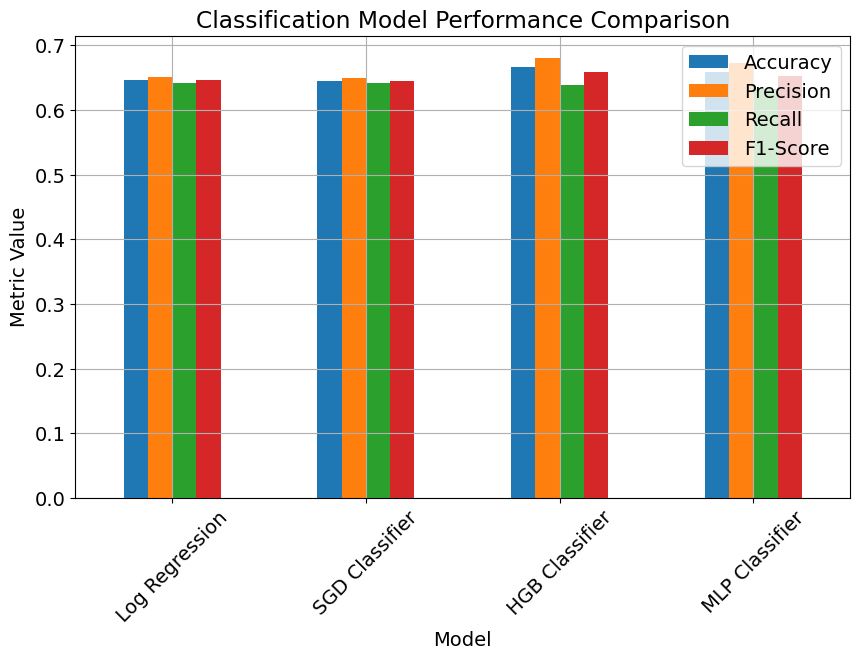

In [16]:
clf_performance_plotter(df_clf_tuned)

### Tuned Model Confusion Matricies

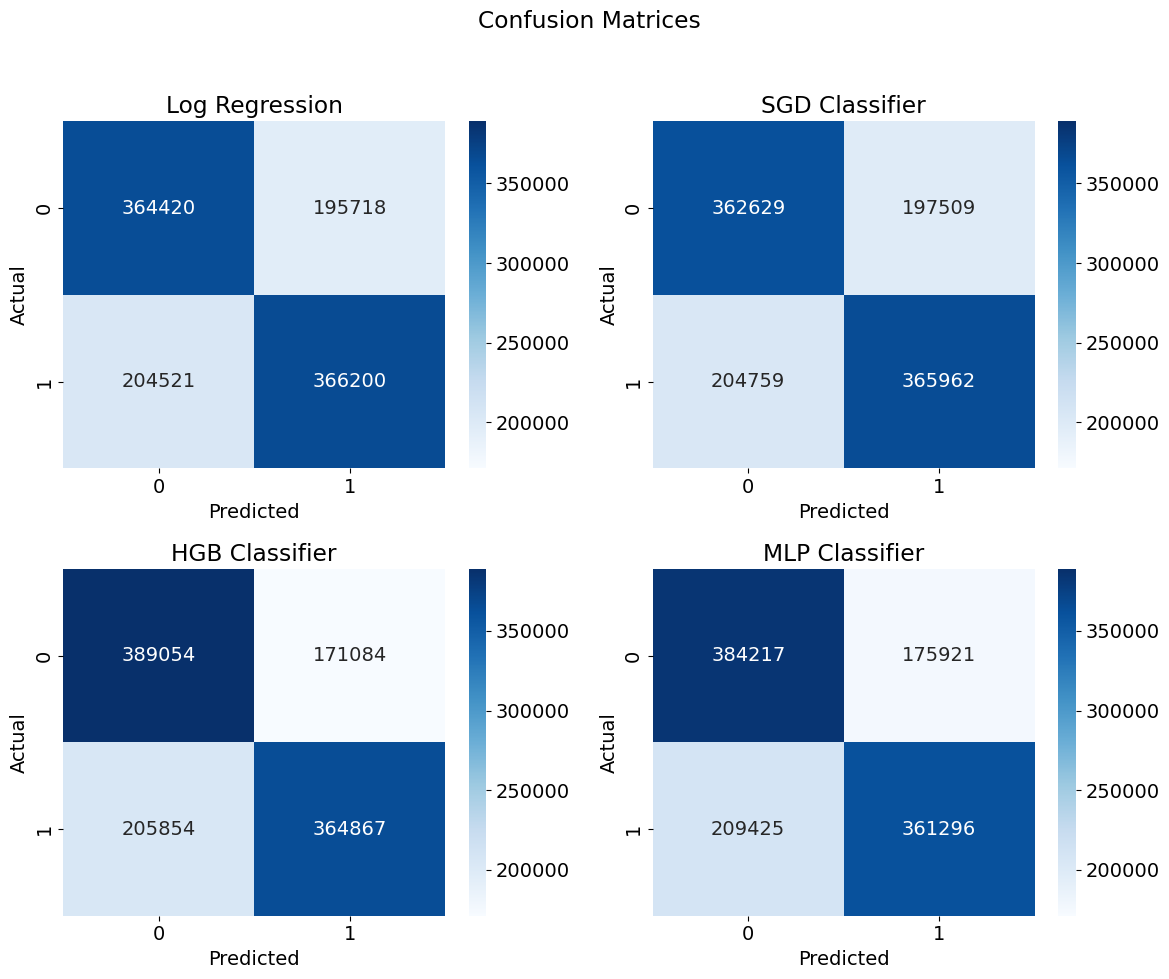

In [17]:
clf_confusion_matrices(classification_models, clf_preds_tuned, y_test)

### Tuned Model AUC-ROC Plot

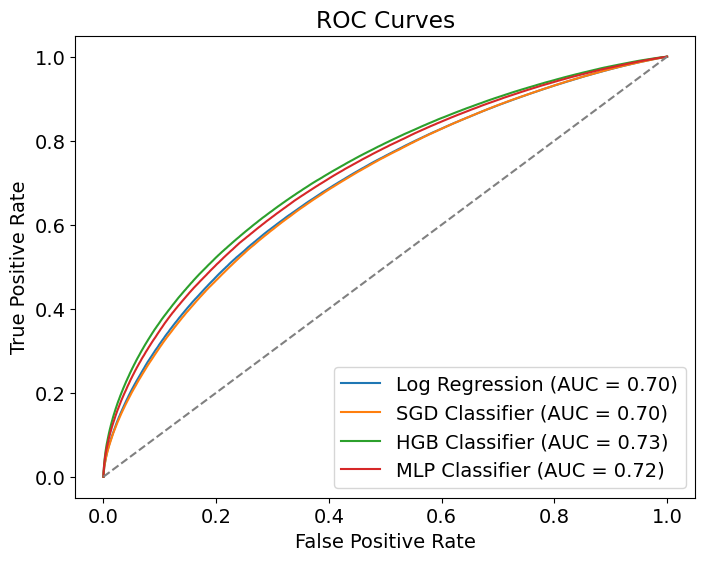

In [18]:
clf_auc_plotter(classification_models, clf_preds_tuned, y_test)

## Tuned Model Feature Importance

In [121]:
df_clf_feature_importance, df_clf_top_features = clf_permutation_importance(classification_models, X_test, y_test)

In [122]:
df_clf_feature_importance

,Feature,Log Regression,SGD Classifier,HGB Classifier,MLP Classifier,Mean Importance
Rank,,,,,,
1.0,CRSDepTime_cos,0.053653,0.036472,0.000773,0.037252,0.032037
2.0,Distance,0.021163,0.017585,0.011991,0.034793,0.021383
3.0,AirTime,0.015031,0.010917,0.011807,0.024373,0.015532
4.0,Airline,0.013558,0.007757,0.020362,0.014166,0.013961
5.0,cumulative_flights_before,0.003053,0.002920,0.013452,0.026087,0.011378
...,...,...,...,...,...,...
59.0,monthly_avg_origin_tmax,-0.000430,0.000000,-0.000071,0.000725,0.000056
60.0,AirTimeCategory,0.000067,0.000000,0.000092,0.000025,0.000046
61.0,weekly_avg_origin_snow,0.000111,0.000000,0.000005,0.000021,0.000034


In [124]:
df_clf_top_features

,Log Regression,SGD Classifier,HGB Classifier,MLP Classifier
Rank,,,,
1,CRSDepTime_cos,CRSDepTime_cos,Airline,CRSDepTime_cos
2,Distance,Distance,cumulative_flights_before,Distance
3,AirTime,past_100_avg_delay,Distance,cumulative_flights_before
4,Airline,AirTime,AirTime,AirTime
5,past_100_avg_delay,Airline,Dest_PRCP,CRSDepTime_sin
